In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy
import string

In [3]:
import sys, os
code_dir = '../code'
sys.path.append(code_dir)

import config
from experiment import get_sinusoidal_parameters, get_sinusoidal_signal
from utils import get_label, zscore

In [4]:
# text
plt.rcParams['text.usetex'] = True
plt.rcParams['pdf.fonttype'] = 42

# plotting
plt.rcParams['lines.linewidth'] = 0.75

In [5]:
def get_lag(x1, x2, t_init, f, dt=1e-4, return_cross=False):
    cross = scipy.signal.correlate(zscore(x1), zscore(x2))
    cross /= cross.max()
    
    lags = -t_init + scipy.signal.correlation_lags(len(x1), len(x2)) * dt

    # only take the correct maxima around the lag of 0 into account
    idx0 = int(t_init/dt) + int(.5/f/dt)
    idx1 = int(1.5/f/dt)
    
    cross = cross[idx0:-idx1]
    lags = lags[idx0:-idx1]
    
    lag = lags[np.argmax(cross)]
    if return_cross:
        return lag, (lags, cross)
    else:
        return lag

In [6]:
from brian2 import ms, mV, exp, exprel

In [7]:
from brian2 import mV, volt, second

In [8]:
v_lin = np.arange(-100, 20, 0.1)


model_type = 'HH_model'
model_name = 'cortex'
eqs = config.model_dynamics[model_type][model_name]['eqs']

eqs = eqs.replace(' ', '')
equations = eqs.split('\n')
variables = ['alpha_m', 'beta_m', 'alpha_h', 'beta_h', 'alpha_n', 'beta_n']

var_eqs = {}
for eq in equations:
    eq = eq.split('=')
    if eq[0] in variables:
        var_eqs[eq[0]] = eq[1].split(':')[0]

gating = {}

tau_m_HH = lambda v: 1/(eval(var_eqs['alpha_m']) + eval(var_eqs['beta_m']))
gating['tau_m'] = tau_m_HH(v_lin * mV)

m_inf_HH = lambda v: eval(var_eqs['alpha_m'])/(eval(var_eqs['alpha_m']) + eval(var_eqs['beta_m']))
gating['m_inf'] = m_inf_HH(v_lin * mV)

tau_h_HH = lambda v: 1/(eval(var_eqs['alpha_h']) + eval(var_eqs['beta_h']))
gating['tau_h'] = tau_h_HH(v_lin * mV)

h_inf_HH = lambda v: eval(var_eqs['alpha_h'])/(eval(var_eqs['alpha_h']) + eval(var_eqs['beta_h']))
gating['h_inf'] = h_inf_HH(v_lin * mV)

n_inf_HH = lambda v: eval(var_eqs['alpha_n'])/(eval(var_eqs['alpha_n']) + eval(var_eqs['beta_n']))
tau_n_HH = lambda v: 1/(eval(var_eqs['alpha_n']) + eval(var_eqs['beta_n']))


In [9]:
# m_inf is sigmoidal
# get sigmoidal fit (and its derivative)

class m_inf_func:
    def __init__(self, *params):
        if len(params) > 0:
            assert len(params) == 2
            self.uh, self.Dh = params
        else:
            self.uh = None
        
    def __call__(self, x, *params):
        if self.uh is None:
            uh, Dh = params
        else:
            uh = self.uh
            Dh = self.Dh

        h_inf = 1 / (1 + np.exp(-(x - uh) / Dh))

        return h_inf

class dm_inf_func:
    def __init__(self, *params):
        self.h_inf = m_inf_func(*params)
        self.um, self.Dm = params
        
    def __call__(self, x):
        return 1/self.Dm * self.h_inf(x) * (1 - self.h_inf(x))

v_ = np.arange(-100, 20, 0.1) * 1e-3
p_opt_g_na = scipy.optimize.curve_fit(m_inf_func(), v_, m_inf_HH(v_*volt), p0=[-65e-3, 1])

print(
    p_opt_g_na[0]
)

um, Dm = p_opt_g_na[0]
m_inf = m_inf_func(*p_opt_g_na[0])
dm_inf = dm_inf_func(*p_opt_g_na[0])

[-0.03845353  0.009     ]


Text(0.5, 0, '$V_{\\rm m}\\,{\\rm [mV]}$')

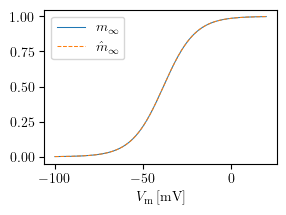

In [10]:
fig, ax = plt.subplots(1, figsize=(3,2))
v_ = np.arange(-.1, .02, 1e-4)
ax.plot(v_*1e3, m_inf_HH(v_*volt), label=get_label('m_inf', unit=False))
ax.plot(v_*1e3, m_inf(v_), ls='--', label=get_label('m_inf', prefix='hat', unit=False))
ax.legend()
ax.set_xlabel(get_label('v'))

In [11]:
# h_inf is an inverted sigmoidal
# get inverted sigmoidal fit (and its derivative)

class h_inf_func:
    def __init__(self, *params):
        if len(params) > 0:
            assert len(params) == 2
            self.uh, self.Dh = params
        else:
            self.uh = None
        
    def __call__(self, x, *params):
        if self.uh is None:
            uh, Dh = params
        else:
            uh = self.uh
            Dh = self.Dh

        h_inf = 1 / (1 + np.exp((x - uh) / Dh))

        return h_inf

class dh_inf_func:
    def __init__(self, *params):
        self.h_inf = h_inf_func(*params)
        self.uh, self.Dh = params
        
    def __call__(self, x):
        return 1/self.Dh * self.h_inf(x) * (self.h_inf(x) - 1)

v_ = np.arange(-100, 20, 0.1) * 1e-3
p_opt_g_na = scipy.optimize.curve_fit(h_inf_func(), v_, h_inf_HH(v_*volt), p0=[-65e-3, 1])

print(
    p_opt_g_na[0]
)
uh, Dh = p_opt_g_na[0]
h_inf = h_inf_func(*p_opt_g_na[0])
dh_inf = dh_inf_func(*p_opt_g_na[0])

[-0.062  0.006]


Text(0.5, 0, '$V_{\\rm m}\\,{\\rm [mV]}$')

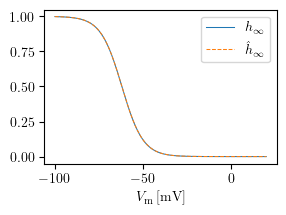

In [12]:
fig, ax = plt.subplots(1, figsize=(3,2))
v_ = np.arange(-.1, .02, 1e-4)
ax.plot(v_*1e3, h_inf_HH(v_*volt), label=get_label('h_inf', unit=False))
ax.plot(v_*1e3, h_inf(v_), ls='--', label=get_label('h_inf', prefix='hat', unit=False))
ax.legend()
ax.set_xlabel(get_label('v'))

In [13]:
class threshold:
    def __init__(self, f=1, tau_r=.1, dt=1e-4, v0=-60e-3, v1=5e-3, T=None, t_from=None, t_to=None, sin_experiment='sinusoidals', sin_id=None, f_freq=10): #I0=0.41e-6, I1=0.5e-6):
        self.args = {**locals()}
        self.args.pop('self')
        if sin_id is None:
            if T is None:
                T = 3
            t = np.arange(-dt, T/f + dt, dt)
            signal = np.sin(2*np.pi*f*t)
            if t_from is None:
                t_from = (T-2) / f
            if t_to is None:
                t_to = (T-1) / f
        else:
            if T is None:
                T = 3
            t = np.arange(-dt, T*f_freq + dt, dt)
            frequencies, amplitudes, phases = get_sinusoidal_parameters(sin_id, experiment_name=sin_experiment)
            frequencies = [f / f_freq for f in frequencies]
            signal = get_sinusoidal_signal(frequencies=frequencies, amplitudes=amplitudes, phases=phases, t=t, zscore=True)
            if t_from is None:
                t_from = (T-2) * f_freq
            if t_to is None:
                t_to = (T-1) * f_freq
        i_from = int(t_from / dt)
        i_to = int(t_to / dt)
        
        
        E_l = -65e-3
        Cm = 1e-6
        g_l = 0.3e-3
    
        I0 = - (E_l - v0) * g_l
        I1 = v1 * g_l
        
        I = I0 + I1 * signal
        
        tht_min = -.06
        tht0 = -.055
        dtht = +.03
        
        p_opt_tht = [tht0, .5*dtht]
        self.tht_inf = lambda x: tht_min + dtht * m_inf_func(*p_opt_tht)(x)
        self.dtht_inf = lambda x: dtht * dm_inf_func(*p_opt_tht)(x)

        f_tau_m = tau_r * (1 - self.dtht_inf(v0)) / self.dtht_inf(v0) / (tau_m_HH(v0*volt)/second)
        
        self.tau_vartht = lambda x: f_tau_m * tau_m_HH(x*volt)/second
        
        v = np.zeros_like(I)
        v[0] = v0
        for i in range(len(v) - 1):
            v[i+1] = v[i] + dt * (g_l * (E_l - v[i]) + I[i]) / Cm
        
        v0 = v.mean()
        dv = (v.max() - v.min())/2
        
        # compute threshold
        vartht = np.zeros_like(v)
        vartht[0] = self.tht_inf(v[0])
        for i in range(len(v) - 1):
            vartht[i+1] = vartht[i] + dt * (self.tht_inf(v[i]) - vartht[i]) / (self.tau_vartht(v[i]))
    
        v_dot = np.diff(v) / 1e-4
        v_dot = v_dot[:-1] + np.diff(v_dot) / 2
    
        self.tau_r = lambda x: self.dtht_inf(x) / (1 - self.dtht_inf(x)) * self.tau_vartht(x)

        v_thr = v - vartht
        
        # v_thr(v + tau_r * v_dot) = v + tau_r * v_dot - thr_inf(v + tau_r * v_dot)
        v_thr_pros = v[1:-1] + self.tau_r(v[1:-1]) * v_dot - self.tht_inf(v[1:-1] + self.tau_r(v[1:-1]) * v_dot)

        self.vartht = vartht[1:-1][i_from:i_to]
        self.v_thr = v_thr[1:-1][i_from:i_to]
        self.t = t[1:-1][i_from:i_to]
        self.v_thr_pros = v_thr_pros[i_from:i_to]
        self.v_long = v[1:-1]
        self.v = v[1:-1][i_from:i_to]
        self.v_dot = v_dot[i_from:i_to]

In [12]:
fs = 10**np.arange(-1, 3, 0.1)
lags = {
    'x': [],
    'x_pros': []
}
plot = False
for i_f, f in enumerate(fs):
    if f > 100:
        T = 5
    elif f > 10:
        T = 4
    else:
        T = 3
    t_init=(T-2)/f
    
    thr = threshold(f=f, tau_r=.1, v1=2.5e-3, T=T)

    lags['x'].append(get_lag(thr.v_long, thr.v_thr, f=f, t_init=t_init))
    lags['x_pros'].append(get_lag(thr.v_long, thr.v_thr_pros, f=f, t_init=t_init))

    if plot:
        fig, axs = plt.subplots(2, figsize=(3,2))
        ax = axs[0]
        axt = ax.twinx()
        axt.plot(thr.t, thr.v, c='k')
        ax.plot(thr.t, zscore(thr.v_thr))
        ax.plot(thr.t, zscore(thr.v_thr_pros), ls='--')
    
        ax.set_title((f, get_lag(thr.v_long, thr.v_thr, f=f, t_init=t_init)))
        ax = axs[1]
        _, (x, y) = get_lag(thr.v_long, thr.v_thr, f=f, t_init=t_init, return_cross=True)
        ax.plot(x, y)
        _, (x, y) = get_lag(thr.v_long, thr.v_thr_pros, f=f, t_init=t_init, return_cross=True)
        ax.plot(x, y)
        # ax.plot(thr.t, thr.tau_r(thr.v))


data = {'fs': fs, 'x': lags['x'], 'x_pros': lags['x_pros'], 'args': thr.args}
    

with open('rate_model_frequency_response_threshold.p', 'wb') as tmp:
    pickle.dump(data, tmp)

In [14]:
thr = threshold(sin_id='004', tau_r=.1, v1=2.5e-3)

In [15]:
class hodgkin:
    def __init__(self, f=1, f_tau_h=1, T=None, dt=1e-4, v0=-60e-3, v1=5e-3, sin_experiment='sinusoidals', sin_id=None, f_freq=1):  #I0=0.41e-6, I1=0.5e-6):
        self.args = {**locals()}
        self.args.pop('self')
        if T is None:
            T = 3
        if sin_id is None:
            t = np.arange(-dt, T/f + dt, dt)
            signal = np.sin(2*np.pi*f*t)
            i_from = int((T-2) / f / dt)
            i_to = int((T-1) / f / dt)
        else:
            t = np.arange(-dt, T*f_freq + dt, dt)
            frequencies, amplitudes, phases = get_sinusoidal_parameters(sin_id, experiment_name=sin_experiment)
            frequencies = [f / f_freq for f in frequencies]
            signal = get_sinusoidal_signal(frequencies=frequencies, amplitudes=amplitudes, phases=phases, t=t, zscore=True)
            i_from = int((T-2) * f_freq / dt)
            i_to = int((T-1) * f_freq / dt)
        
        
        
        
        E_l = -65e-3
        Cm = 1e-6
        g_l = 0.3e-3
    
        I0 = - (E_l - v0) * g_l
        I1 = v1 * g_l
        
        I = I0 + I1 * signal
        self.I = I[1:-1][i_from:i_to]
    
        self.tau_g = lambda x: - m_inf(x)**3 * dh_inf(x) * f_tau_h * tau_h_HH(x*volt)/second
        self.tau_na = lambda x: self.tau_g(x) / (3 * dm_inf(x) * m_inf(x)**2 * h_inf(x) + m_inf(x)**3 * dh_inf(x))
        self.gN = lambda x: m_inf(x)**3 * h_inf(x)
        
        v = np.zeros_like(I)
        v[0] = E_l
        
        m = np.zeros_like(v)
        h = np.zeros_like(v)
        m[0] = m_inf(v[0])
        h[0] = h_inf(v[0])

        
        for i in range(len(v) - 1):
            v[i+1] = v[i] + dt * (g_l * (E_l - v[i]) + I[i]) / Cm
            m[i+1] = m[i] + dt * (m_inf(v[i]) - m[i]) / (tau_m_HH(v[i]*volt)/second)
            h[i+1] = h[i] + dt * (h_inf(v[i]) - h[i]) / (f_tau_h * tau_h_HH(v[i]*volt)/second)

        
        v0 = v.mean()
        dv = (v.max() - v.min())/2
    
        v_dot = np.diff(v) / 1e-4
        v_dot = v_dot[:-1] + np.diff(v_dot) / 2
    
        g_na = m**3*h
        g_pros = self.gN(v[1:-1] + self.tau_na(v[1:-1]) * v_dot)

        
        self.t = t[1:-1][i_from:i_to]
        self.v_long = v[1:-1]
        self.v = v[1:-1][i_from:i_to]
        self.v_dot = v_dot[i_from:i_to]
        self.g_na = g_na[1:-1][i_from:i_to]
        self.g_pros = g_pros[i_from:i_to]

In [ ]:
fs = 10**np.arange(-1, 3, 0.1)
lags = {
    'x': [],
    'x_pros': []
}
plot = False
for i_f, f in enumerate(fs):
    if f > 100:
        T = 5
    elif f > 10:
        T = 4
    else:
        T = 3
    t_init=(T-2)/f

    hh = hodgkin(f=f, v1=2.5e-3, T=T)

    lags['x'].append(get_lag(hh.v_long, hh.g_na, f=f, t_init=t_init))
    lags['x_pros'].append(get_lag(hh.v_long, hh.g_pros, f=f, t_init=t_init))

    if plot:
        fig, axs = plt.subplots(2, figsize=(3,2))
        ax = axs[0]
        axt = ax.twinx()
        axt.plot(hh.t, hh.v, c='k')
        ax.plot(hh.t, hh.g_na)
        ax.plot(hh.t, hh.g_pros, ls='--')
    
        ax.set_title((f, get_lag(hh.v_long, hh.g_na, f=f, t_init=t_init)))
        ax = axs[1]
        _, (x, y) = get_lag(hh.v_long, hh.g_na, f=f, t_init=t_init, return_cross=True)
        ax.plot(x, y)
        _, (x, y) = get_lag(hh.v_long, hh.g_pros, f=f, t_init=t_init, return_cross=True)
        ax.plot(x, y)


data = {'fs': fs, 'x': lags['x'], 'x_pros': lags['x_pros'], 'args': hh.args}
    

with open('rate_model_frequency_response_HH.p', 'wb') as tmp:
    pickle.dump(data, tmp)

In [16]:
hh = hodgkin(sin_id='004', v1=2.5e-3)

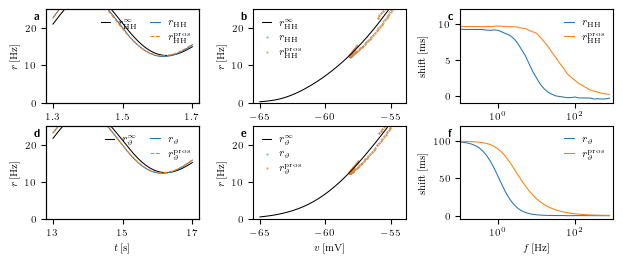

In [17]:
####################################################
# HH model
####################################################

gridspec_kw = {'wspace': .8}
fsize = 1
fontsize = fsize*7
handlelength = 1

wspace = .4

plot_kw = {'lw': 0.75}

import matplotlib.gridspec as gridspec
figsize=(fsize*6.2,fsize*2.5)
gridspec_kw = {'hspace': .25, 'wspace': .35, 'left': .075, 'bottom': .15, 'right': .99, 'top': .99, }

fig, axs = plt.subplots(2, 3, figsize=figsize, gridspec_kw=gridspec_kw)

cmap = plt.colormaps['tab10']
dt = 1e-4
i_from = int(.3/dt)
i_to = int(.7/dt)

ax = axs[0,0]
axt = ax.twinx()

beta = 1
act = lambda x:1/beta * np.log(1 + np.exp(beta * (x * 5e4 - 5)))

label_HH = r'$r_{\rm HH}$'
label_HH_inf = label_HH[:-1] + r'^\infty$'
label_HH_pros = label_HH[:-1] + r'^{\rm pros}$'


label_thr = r'$r_\vartheta$'
label_thr_inf = label_thr[:-1] + r'^\infty$'
label_thr_pros = label_thr[:-1] + r'^{\rm pros}$'

label = label_HH_inf
ax.plot(hh.t[i_from:i_to], act(hh.gN(hh.v))[i_from:i_to], c='k', label=label, **plot_kw)
label = label_HH
axt.plot(hh.t[i_from:i_to], act(hh.g_na)[i_from:i_to], c=cmap(0), label=label, **plot_kw)
label = label_HH_pros
axt.plot(hh.t[i_from:i_to], act(hh.g_pros)[i_from:i_to], c=cmap(1), label=label, ls='--', **plot_kw)
ax.set_ylabel(r'$r\,{\rm [Hz]}$', size=fontsize)

for ax_ in [ax, axt]:
    ylim = ax_.get_ylim()
    dy = np.array(ylim).ptp()
    ax_.set_ylim([ylim[0], ylim[1] + .2*dy])

axt.set_yticks([])
ax.set_yticks([0, 10, 20])
    

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = axt.get_legend_handles_labels()
ax.legend(loc='upper right', fontsize=fontsize, frameon=False, bbox_to_anchor=(.65, 1), handlelength=handlelength)
axt.legend(loc='upper right', fontsize=fontsize, frameon=False, bbox_to_anchor=(1, 1), handlelength=handlelength)

ax.tick_params(labelsize=fontsize)
axt.tick_params(labelsize=fontsize)

ylim = [0, 25]
ax.set_ylim(ylim)
axt.set_ylim(ylim)

ax = axs[0, 1]
v_ = np.arange(-.065, -.055, 1e-4)
every = 50
label = label_HH_inf
ax.plot(1e3*v_, act(hh.gN(v_)), c='k', label=label, **plot_kw)

label = label_HH
ax.scatter(1e3*hh.v[i_from:i_to:every], act(hh.g_na)[i_from:i_to:every], s=.1, color=cmap(0), label=label)

label = label_HH_pros
ax.scatter(1e3*hh.v[i_from:i_to:every], act(hh.g_pros)[i_from:i_to:every], s=.2, color=cmap(1), label=label)

ax.tick_params(labelsize=fontsize)
label = r'$r\,{\rm [Hz]}$'
ax.set_ylabel(label, size=fontsize)
lines, labels = ax.get_legend_handles_labels()

ylim = [0, 25]
ax.set_ylim(ylim)
ax.set_yticks([0, 10, 20])
ax.legend(lines, labels, loc='upper left', fontsize=fontsize, frameon=False, handlelength=handlelength)

ax = axs[0, 2]
with open('rate_model_frequency_response_HH.p', 'rb') as tmp:
    
    data = pickle.load(tmp)
i_from = 0
label = label_HH
ax.plot(data['fs'][i_from:], 1e3*np.array(data['x'])[i_from:], c=cmap(0), label=label, **plot_kw)
label = label_HH_pros
ax.plot(data['fs'][i_from:], 1e3*np.array(data['x_pros'])[i_from:], c=cmap(1), label=label, **plot_kw)
ax.set_xscale('log')
ax.tick_params(labelsize=fontsize)
ax.set_ylabel(r'${\rm shift\,[ms]}$', size=fontsize)
ax.legend(fontsize=fontsize, loc='upper right', frameon=False, handlelength=handlelength)  # (0, 1.1)  (.03, .05)
ax.set_yticks([0, 5, 10])
ax.set_ylim([ax.get_ylim()[0], 12])


####################################################
# threshold model
####################################################

cmap = plt.colormaps['tab10']
i_from = int(3/dt)
i_to = int(7/dt)

ax = axs[1,0]
axt = ax.twinx()

beta = .1
act = lambda x:1/beta * np.log(1 + np.exp(beta * ((x + .0125) * 1e4)))

label=r'$v$'
label = label_thr_inf
ax.plot(thr.t[i_from:i_to], act(thr.v - thr.tht_inf(thr.v))[i_from:i_to], c='k', label=label, **plot_kw)
label = label_thr
axt.plot(thr.t[i_from:i_to], act(thr.v - thr.vartht)[i_from:i_to], c=cmap(0), label=label, **plot_kw)
label = label_thr_pros
axt.plot(thr.t[i_from:i_to], act(thr.v_thr_pros)[i_from:i_to], c=cmap(1), ls='--', label=label, **plot_kw)

ax.set_xlabel(r'$t\,{\rm [s]}$', size=fontsize)
ax.set_ylabel(r'$r\,{\rm [Hz]}$', size=fontsize)

for ax_ in [ax, axt]:
    ylim = ax_.get_ylim()
    dy = np.array(ylim).ptp()
    ax_.set_ylim([ylim[0], ylim[1] + .2*dy])

axt.set_yticks([])
ax.set_yticks([0, 10, 20])


lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = axt.get_legend_handles_labels()
ax.legend(loc='upper right', fontsize=fontsize, frameon=False, bbox_to_anchor=(.65, 1), handlelength=handlelength)
axt.legend(loc='upper right', fontsize=fontsize, frameon=False, bbox_to_anchor=(1, 1), handlelength=handlelength)

ax.tick_params(labelsize=fontsize)
axt.tick_params(labelsize=fontsize)

ylim = [0, 25]
ax.set_ylim(ylim)
axt.set_ylim(ylim)

ax = axs[1,1]
v_ = np.arange(-.065, -.055, 1e-4)
every = 500
label = label_thr_inf
ax.plot(1e3*v_, act(v_ - thr.tht_inf(v_)), c='k', label=label, **plot_kw)

label = label_thr
ax.scatter(1e3*thr.v[i_from:i_to:every], act(thr.v - thr.vartht)[i_from:i_to:every], s=.1, color=cmap(0), label=label)

label = label_thr_pros
ax.scatter(1e3*thr.v[i_from:i_to:every], act(thr.v_thr_pros)[i_from:i_to:every], s=.2, color=cmap(1), label=label)

ax.tick_params(labelsize=fontsize)
ax.set_xlabel(r'$v\,{\rm [mV]}$', size=fontsize)
label = r'$r\,{\rm [Hz]}$'
ax.set_ylabel(label, size=fontsize)
lines, labels = ax.get_legend_handles_labels()

ylim = [0, 25]
ax.set_ylim(ylim)
ax.set_yticks([0, 10, 20])

leg = ax.legend(lines, labels, loc='upper left', fontsize=fontsize, frameon=False, handlelength=handlelength)


ax = axs[1,2]
with open('rate_model_frequency_response_threshold.p', 'rb') as tmp:
    
    data = pickle.load(tmp)#['100ms']
i_from = 0
label = label_thr
ax.plot(data['fs'][i_from:], 1e3*np.array(data['x'])[i_from:], c=cmap(0), label=label, **plot_kw)
label = label_thr_pros
ax.plot(data['fs'][i_from:], 1e3*np.array(data['x_pros'])[i_from:], c=cmap(1), label=label, **plot_kw)
ax.set_xscale('log')
ax.tick_params(labelsize=fontsize)
ax.set_xlabel(r'$f\,{\rm [Hz]}$', size=fontsize)
ax.set_ylabel(r'${\rm shift\,[ms]}$', size=fontsize)
ax.legend(fontsize=fontsize, loc='upper right', frameon=False, handlelength=handlelength)  # (0, 1.1)  (.03, .05)
ax.set_yticks([0, 50, 100])
ax.set_ylim([ax.get_ylim()[0], 120])


i = 0
for ax in axs.reshape(-1):
    ax.tick_params(labelsize=fontsize)
    p_ = r'${\textbf ' + string.ascii_lowercase[i] + '}$'
    ax.text(-.075, .975, p_, fontsize=8, transform=ax.transAxes, va='top', ha='left', weight='bold')
    i += 1

for i in range(3):
    fig.align_ylabels([axs[0, i], axs[1, i]])

axs[0,0].set_xticks([1.3, 1.5, 1.7])
axs[1,0].set_xticks([13, 15, 17])

    
for ax in axs[:, 1]:
    ax.set_xticks([-65, -60, -55])

for ax in axs[:, 2]:
    ax.set_xlim([0.1, 1000])
    ax.set_xticks([1, 100])
    ax.minorticks_off()

save_str = 'Fig-5_theory'
# plt.savefig(save_str + '.svg', dpi=300, transparent=True)
# plt.savefig(save_str + '.pdf', dpi=300, transparent=True)